In [1]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from tensorflow.keras import layers, models

from skimage.transform import resize

import matplotlib.pyplot as plt
import csv

import random

In [2]:
#Parameter

#Speicherort der Test-Daten for example './GTSRB/Training'
TRAINING_DATA_PATH = "C:/Users/de136581/Documents/Uni/SoSe_2024/DSKI_Projekt/Data_trafic_Signs/Final_Training/GTSRB/Final_Training/Images" #"Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images" #

TEST_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Online-Test-Images/GTSRB/Online-Test/Images"

In [3]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def format_imgs(imgs_lst):
    new_size = (32, 32)
    resized_images = []
    for img in imgs_lst:
        resized_img = resize(img, new_size, anti_aliasing=True)
        resized_images.append(resized_img)

    return np.array(resized_images)

In [4]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

In [5]:
# Train-Test-Aufteilung
img_train, img_test, labels_train, labels_test = train_test_split(trainImages,  trainLabels, test_size=0.2, random_state=42)
# One-Hot-Encoding der Labels
labels_train = to_categorical(labels_train, 43)
labels_test = to_categorical(labels_test, 43)

img_train  = format_imgs(img_train)
img_test = format_imgs(img_test)

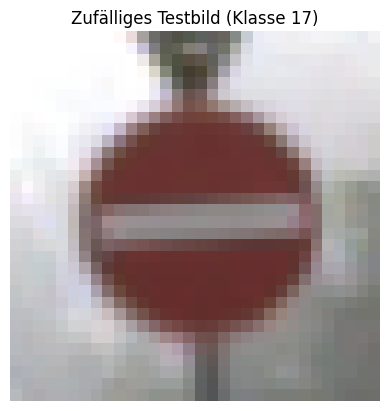

In [6]:
# Wähle ein zufälliges Bild aus dem Testdatensatz
random_index = np.random.randint(0, len(img_test))
test_image = img_train[random_index]
true_label = labels_train[random_index]

# Zeige das Bild an
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild (Klasse {np.argmax(true_label)})")
plt.axis('off')
plt.show()

In [7]:
# Modellarchitektur
# Definiere das Modell
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))  # 43 Klassen für Verkehrszeichen

# Kompiliere das Modell
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\de136581\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.fit(img_train, labels_train, epochs=10, batch_size=32) #, validation_data=(img_test, labels_test)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4883 - loss: 2.0005
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9277 - loss: 0.2928
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9652 - loss: 0.1456
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9782 - loss: 0.0910
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9854 - loss: 0.0646
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9864 - loss: 0.0532
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9906 - loss: 0.0383
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9896 - loss: 0.0341
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9913 - loss: 0.0310
Epoch 10/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9913 - loss: 0.0319


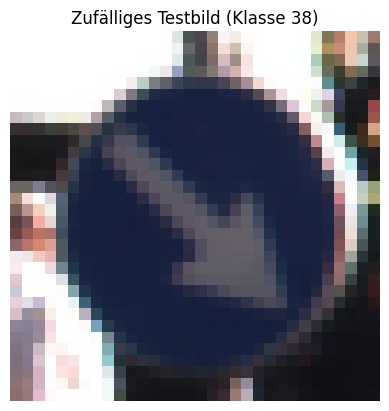

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Vorhergesagte Klasse: 38
Wahrscheinlichkeit: 1.00


In [15]:
#Testen des Modells:
    
# Wähle ein zufälliges Bild aus dem Testdatensatz
random_index = np.random.randint(0, len(img_test))
test_image = img_test[random_index]
true_label = labels_test[random_index]

# Zeige das Bild an
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild (Klasse {np.argmax(true_label)})")
plt.axis('off')
plt.show()

# Klassifiziere das Bild mit dem trainierten Modell
predicted_probs = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(predicted_probs)

# Gib die Klassifizierung und die Wahrscheinlichkeit aus
print(f"Vorhergesagte Klasse: {predicted_class}")
print(f"Wahrscheinlichkeit: {predicted_probs[0][predicted_class]:.2f}")